# Collaborative Filtering Recommender System- Expedia Hotel dataset
# Using fastAi 

## This notebook should be placed at the Recommenders folder (reco library environment)
https://github.com/microsoft/recommenders

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
import warnings


from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from fastai.collab import *

import time
import os
import itertools
import papermill as pm
import torch, fastai

from reco_utils.dataset import movielens
from reco_utils.dataset.python_splitters import python_stratified_split
from reco_utils.recommender.fastai.fastai_utils import cartesian_product, score
from reco_utils.evaluation.python_evaluation import precision_at_k, recall_at_k,rmse, mae

In [2]:
user_id, item_id, rating, TIMESTAMP, PREDICTION, TITLE = 'user_id', 'item_id', 'rating', 'Timestamp', 'Prediction', 'title'

In [3]:
# top k items to recommend
TOP_K = 10

### Import Dataset

In [7]:
hotel_train_set = pd.read_csv('data/hotel_data/train.csv', sep=',', nrows=100000)
hotel_train_set.shape

(100000, 24)

In [8]:
ratings_df = hotel_train_set[['user_id','hotel_cluster','is_booking']]
ratings_df.head()

,user_id,hotel_cluster,is_booking
0,12,1,0
1,12,1,1
2,12,1,0
3,93,80,0
4,93,21,0


In [9]:
ratings_df.columns =['user_id', 'item_id', 'rating']

In [10]:
warnings.filterwarnings("ignore")
# make sure the IDs are loaded as strings to better prevent confusion with embedding ids
ratings_df[user_id] = ratings_df[user_id].astype('str')
ratings_df[item_id] = ratings_df[item_id].astype('str')
ratings_df.head()

,user_id,item_id,rating
0,12,1,0
1,12,1,1
2,12,1,0
3,93,80,0
4,93,21,0


### Remove rows with the same user_id and item_id and different rating

In [11]:
max_rating = ratings_df.groupby(['user_id', 'item_id']).rating.transform(max)
ratings_df = ratings_df.loc[ratings_df.rating == max_rating]
ratings_df.drop_duplicates(keep='first',inplace=True) 

In [12]:
ratings_df.head()

,user_id,item_id,rating
1,12,1,1
3,93,80,0
4,93,21,0
5,93,92,0
6,501,41,0


### Split Train and Test

In [13]:
# Split the dataset
train_valid_df, test_df = python_stratified_split(
    ratings_df, 
    ratio=0.75, 
    min_rating=1, 
    filter_by="item", 
    col_user=user_id, 
    col_item=item_id
)

In [14]:
# fix random seeds to make sure our runs are reproducible
np.random.seed(101)
torch.manual_seed(101)
torch.cuda.manual_seed_all(101)

## Fast AI

### Training

In [15]:
# Turn the columns in category codes(to replace them with their codes for an Embedding layer)
# size of our validation set = 0.1 (or 0)
# we can add rating_name and user_name too.
# train on trainset
data = CollabDataBunch.from_df(train_valid_df, seed=42, valid_pct=0.1, 
                                      user_name='user_id', item_name='item_id', rating_name='rating')

In [16]:
data.show_batch()

user_id,item_id,target
288887,7,0.0
110498,18,0.0
366552,58,0.0
329391,68,0.0
85275,66,0.0


In [17]:
train_valid_df['rating'].min(),train_valid_df['rating'].max()

(0, 1)

In [18]:
# Lastly, we set a value for weight-decay for regularization.
learn = collab_learner(data, n_factors=40, y_range=[0,1], wd=1e-1)
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(3386, 40)
  (i_weight): Embedding(101, 40)
  (u_bias): Embedding(3386, 1)
  (i_bias): Embedding(101, 1)
)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


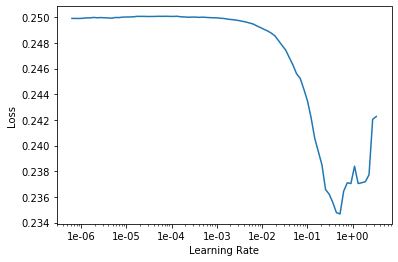

In [19]:
# find the perfect learning rates we can use the lr_find 
learn.lr_find()
# plot learning rate graph
learn.recorder.plot()

In [20]:
# Train our model using the fit_one_cycle method
learn.fit_one_cycle(5, 1e-02)  

epoch,train_loss,valid_loss,time
0,0.148435,0.137160,00:03
1,0.121986,0.130385,00:03
2,0.101208,0.135054,00:04
3,0.063447,0.138874,00:03
4,0.043613,0.139704,00:03


In [21]:
#Save the learner so it can be loaded back later for inferencing / generating recommendations
learn.save('expedia_model')

In [22]:
learner = learn.load('expedia_model')

## Generating Recommendations

In [23]:
#Get all users and items that the model knows
total_users, total_items = learner.data.train_ds.x.classes.values()
total_items = total_items[1:]
total_users = total_users[1:]
len(total_items),len(total_users)

(100, 3385)

In [24]:
#Get all users from the test set and remove any users that were know in the training set
test_users = test_df[user_id].unique()
test_users = np.intersect1d(test_users, total_users)
len(test_users)

2727

In [25]:
#Build the cartesian product of test set users and all items known to the model
users_items = cartesian_product(np.array(test_users),np.array(total_items))
users_items = pd.DataFrame(users_items, columns=[user_id,item_id])

users_items.head()

,user_id,item_id
0,100025,0
1,100025,1
2,100025,10
3,100025,11
4,100025,12


In [30]:
#Lastly, remove the user/items combinations that are in the training set
#we don't want to propose a hotel that the user has already booked. (Although we can ignore this step)
training_removed = pd.merge(users_items, train_valid_df.astype(str), on=[user_id, item_id], how='left')
training_removed = training_removed[training_removed[rating].isna()][[user_id, item_id]]
training_removed.head()

,user_id,item_id
0,100025,0
1,100025,1
2,100025,10
3,100025,11
4,100025,12


### Score the model to find the top K recommendation

In [31]:
top_k_scores = score(learner, 
                     test_df=training_removed,
                     user_col=user_id, 
                     item_col=item_id, 
                     prediction_col=PREDICTION)

## Evaluation

In [54]:
eval_precision = precision_at_k(test_df, top_k_scores, col_user=user_id, col_item=item_id, 
                    col_rating=rating, col_prediction=PREDICTION,
                                relevancy_method="top_k", k=TOP_K)

In [55]:
eval_recall = recall_at_k(test_df, top_k_scores, col_user=user_id, col_item=item_id, 
                    col_rating=rating, col_prediction=PREDICTION, 
                          relevancy_method="top_k", k=TOP_K)

In [56]:
train_valid_df.head()

,user_id,item_id,rating
50986,184541,0,0
87805,351165,0,0
10094,54818,0,0
53290,190433,0,0
26834,112773,0,0


In [ ]:
'''scores = score(learner, 
               test_df=test_df.copy(), 
               user_col=user_id, 
               item_col=item_id, 
               prediction_col=PREDICTION)
scores.head()'''

In [ ]:
'''eval_r2 = rsquared(test_df, scores, col_user=user_id, col_item=item_id, col_rating=rating, col_prediction=PREDICTION)
eval_rmse = rmse(test_df, scores, col_user=user_id, col_item=item_id, col_rating=rating, col_prediction=PREDICTION)
eval_mae = mae(test_df, scores, col_user=user_id, col_item=item_id, col_rating=rating, col_prediction=PREDICTION)'''

In [ ]:
'''print("Model:\t" + learn.__class__.__name__,
      "Top K:\t%d" % TOP_K,
      "RMSE:\t%f" % eval_rmse,
      "MAE:\t%f" % eval_mae,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, 
      "R squared:\t%f" % eval_r2, sep='\n')'''

### Prediction using get_preds

In [82]:
preds, y = learn.get_preds(ds_type=DatasetType.Valid)

In [83]:
len(preds)

3060

In [84]:
len(top_k_scores['Prediction'])

244588

In [85]:
y, y.shape

(tensor([0., 0., 1.,  ..., 0., 0., 0.]), torch.Size([3060]))

### Evluation using Fastai library

In [61]:
print("Model:\t" + learn.__class__.__name__,
      "Top K:\t%d" % TOP_K,
      "RMSE:\t%f" % root_mean_squared_error(preds, y),
      "MAE:\t%f" % mean_absolute_error(preds, y),
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

#"R squared:\t%f" % eval_r2, 

Model:	CollabLearner
Top K:	10
RMSE:	0.373769
MAE:	0.277387
Precision@K:	0.049175
Recall@K:	0.127460


## ROC and AUC

ROC, as well as AUC, is a well known metric that is used for evaluating binary classification problem. It is similar in the case of binary rating typed recommendation algorithm where the "hit" accuracy on the relevant items is used for measuring the recommender's performance.
To demonstrate the evaluation method, the original data for testing is manipuldated in a way that the ratings in the testing data are arranged as binary scores, whilst the ones in the prediction are scaled in 0 to 1

In [86]:
# Convert the original rating to 0 and 1.
df_true_bin = ratings_df.copy()
df_true_bin[rating] = ratings_df[rating] #df_true_bin[rating].apply(lambda x: 1 if x > 3 else 0)

In [87]:
from sklearn.preprocessing import minmax_scale
# Convert the predicted ratings into a [0, 1] scale.
df_pred_bin = top_k_scores.copy()
df_pred_bin[PREDICTION] = minmax_scale(df_pred_bin[PREDICTION].astype(float))

df_pred_bin.head()

,user_id,item_id,Prediction
38,100025,43,0.677383
15,100025,22,0.629098
34,100025,4,0.623681
43,100025,48,0.606639
8,100025,16,0.587207


In [104]:
# Calculate the AUC metric

auc = roc_auc_score(y.numpy(), preds.numpy())

#from reco_utils.evaluation.python_evaluation import auc, logloss
#auc_score = auc(
#    df_true_bin,
#    df_pred_bin,
#    col_user = user_id,
#    col_item = item_id,
#    col_rating = rating,
#    col_prediction = PREDICTION)

In [105]:
print("The auc score is {}".format(auc))

The auc score is 0.6606154072638857


In [102]:
auc = roc_auc_score(y.numpy(), preds.numpy())

0.6606154072638857

In [129]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y.numpy(), preds.numpy(), pos_label=2)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.661


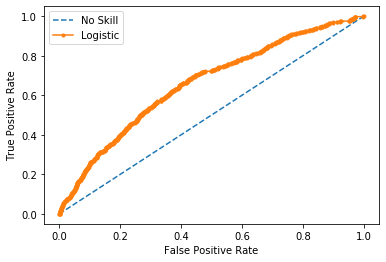

In [128]:
# roc curve and auc

#from sklearn.metrics import roc_curve
#from sklearn.metrics import roc_auc_score
#from matplotlib import pyplot

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y))]
# predict probabilities
lr_probs = preds.numpy()

# calculate scores
ns_auc = roc_auc_score(y.numpy(), ns_probs)
lr_auc = roc_auc_score(y.numpy(), lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y.numpy(), ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y.numpy(), lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Recommend hotel cluster for a user

In [183]:
rows = []
movies = list(ratings_df.drop_duplicates(subset='item_id', keep='first').item_id)
names = list(ratings_df.drop_duplicates(subset='item_id', keep='first').item_id)

for i in range(len(movies)):
    rows.append( dict({'name': names[i], 'item_id' : movies[i], 'user_id' : 9}))
test_data = pd.DataFrame(rows)

In [184]:
for idx, (score, name) in enumerate(sorted(zip(preds, names), reverse=True)):
    if idx >= 10:
        break
    print("Score: ", round(float(score), 2), " for hotel cluster: ", name)

Score:  0.7  for hotel cluster:  8
Score:  0.69  for hotel cluster:  29
Score:  0.63  for hotel cluster:  35
Score:  0.62  for hotel cluster:  52
Score:  0.6  for hotel cluster:  19
Score:  0.57  for hotel cluster:  28
Score:  0.57  for hotel cluster:  9
Score:  0.52  for hotel cluster:  43
Score:  0.52  for hotel cluster:  48
Score:  0.51  for hotel cluster:  94


# Resoursec

https://docs.fast.ai/metrics.html#root_mean_squared_error